<a href="https://colab.research.google.com/github/jrzkaminski/dmm_homeworks/blob/main/Tasks_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Impotring libraries

In [ ]:
!pip install simpy
!pip install SALib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import simpy as sp
from SALib.sample import saltelli
from SALib.analyze import sobol

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path for all the data
path = '/content/drive/My Drive/ITMO/1.2/dmm/data/'


In [ ]:
plt.style.use('seaborn-pastel')

# Lab 1

Task
*   Determine the «survival» rates independently for men and women for all age groups (“0-4” -> “5-9” -> “10-14” ...) according to 2000-2005 years (data for Russia or any other country)
*   Determine the fertility rate for women in the age category “20- ... -39”
*   Calculate boys/girls ratio for newborn children
*   Predict the change in the country's population and demographic profile for 100 years and compare with existing prediction!


For that:
*   Write out equations for modeling
*   Define input/output data and parameters

In [ ]:
target_country = "Poland" # set target country

## 1.0 Importing data

### population by age

In [ ]:
population_by_age = pd.read_excel(path + 'POPULATION_BY_AGE_BOTH_SEXES.xlsx', skiprows=16, sheet_name='ESTIMATES') 
filter_pop = population_by_age["Region, subregion, country or area *"] == target_country
population_by_age_both_target = population_by_age[filter_pop]


In [ ]:
population_by_age_male = pd.read_excel(path + 'POPULATION_BY_AGE_MALE.xlsx', skiprows=16, sheet_name='ESTIMATES') 
filter_pop_male = population_by_age_male["Region, subregion, country or area *"] == target_country
population_by_age_male_target = population_by_age_male[filter_pop_male]


In [ ]:
population_by_age_female = pd.read_excel(path + 'POPULATION_BY_AGE_FEMALE.xlsx', skiprows=16, sheet_name='ESTIMATES') 
filter_pop_female = population_by_age_female["Region, subregion, country or area *"] == target_country
population_by_age_female_target = population_by_age_female[filter_pop_female]


### total population

In [ ]:
total_population_both = pd.read_excel(path + 'TOTAL_POPULATION_BOTH_SEXES.xlsx', skiprows=16, sheet_name='ESTIMATES') 
filter_tpop = total_population_both["Region, subregion, country or area *"] == target_country
total_population_both_target = total_population_both[filter_tpop]

In [ ]:
total_population_both_forecast = pd.read_excel(path + 'TOTAL_POPULATION_BOTH_SEXES.xlsx', skiprows=16, sheet_name='MEDIUM VARIANT') 
filter_tpop = total_population_both_forecast["Region, subregion, country or area *"] == target_country
total_population_both_forecast_target = total_population_both_forecast[filter_tpop]

In [ ]:
total_population_male = pd.read_excel(path + 'TOTAL_POPULATION_MALE.xlsx', skiprows=16, sheet_name='ESTIMATES') 
filter_tpop = total_population_male["Region, subregion, country or area *"] == target_country
total_population_male_target = total_population_male[filter_tpop]

In [ ]:
total_population_female = pd.read_excel(path + 'TOTAL_POPULATION_FEMALE.xlsx', skiprows=16, sheet_name='ESTIMATES') 
filter_tpop = total_population_female["Region, subregion, country or area *"] == target_country
total_population_female_target = total_population_female[filter_tpop]

### Sex ratio total/at birth

In [ ]:
sex_ratio = pd.read_excel(path + 'SEX_RATIO_OF_TOTAL_POPULATION.xlsx', skiprows=16, sheet_name='ESTIMATES') 
filter_sr = sex_ratio["Region, subregion, country or area *"] == target_country
sex_ratio_target = sex_ratio[filter_sr]
sex_ratio_target

,Index,Variant,"Region, subregion, country or area *",Notes,Country code,Type,Parent code,1950,1955,1960,...,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
213,214,Estimates,Poland,NaN,616,Country/Area,923,91.042,92.198,93.678,...,94.705,94.79,95.028,94.912,94.697,94.353,93.861,93.608,94.059,93.998


In [ ]:
sex_ratio_at_birth = pd.read_excel(path + 'SEX_RATIO_AT_BIRTH.xlsx', skiprows=16, sheet_name='ESTIMATES') 
filter_sr = sex_ratio_at_birth["Region, subregion, country or area *"] == target_country
sex_ratio_at_birth_target = sex_ratio_at_birth[filter_sr]
sex_ratio_at_birth_target

,Index,Variant,"Region, subregion, country or area *",Notes,Country code,Type,Parent code,1950-1955,1955-1960,1960-1965,...,1970-1975,1975-1980,1980-1985,1985-1990,1990-1995,1995-2000,2000-2005,2005-2010,2010-2015,2015-2020
213,214,Estimates,Poland,NaN,616,Country/Area,923,1.056,1.056,1.056,...,1.056,1.056,1.056,1.056,1.056,1.056,1.056,1.056,1.056,1.056


## 1.1 Determination of Survivial Rates

### Visualisation of demographic profiles for each time period

In [ ]:
dp = population_by_age_both_target.iloc[:, 7:]
dp_m = population_by_age_male_target.iloc[:, 7:]
dp_f = population_by_age_female_target.iloc[:, 7:]
dp

,Reference date (as of 1 July),0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
3195,1950,2950,2022,2322.998,2411.999,2369.001,2108,1355.002,1765.998,1793,...,899.998,746.998,531,354.002,230,120.736,47.996,12.301,1.828,0.151
3196,1955,3549.007,2907.684,2011.696,2308.995,2385,2333.988,2074.059,1329.137,1724.165,...,1147.66,811.924,634.644,410.493,236.099,122.601,46.906,12.631,2.03,0.182
3197,1960,3592.221,3479.223,2865.709,1953.366,2218.327,2329.262,2305.579,2050.916,1250.87,...,1416.552,1067.344,698.826,504.063,283.691,132.631,51.351,13.373,2.248,0.216
3198,1965,2816.943,3558.361,3461.91,2850.08,1938.464,2197.592,2303.005,2273.856,2024.781,...,1636.622,1311.044,945.284,576.769,368.52,169.067,58.724,15.429,2.428,0.234
3199,1970,2561.214,2790.492,3536.043,3439.329,2816.369,1909.483,2171.6,2272.986,2233.726,...,1545.243,1515.363,1161.487,776.754,422.909,221.41,75.485,17.88,2.898,0.259
3200,1975,2806.058,2533.191,2778.951,3508.68,3387.14,2774.516,1881.016,2141.383,2231.534,...,1132.782,1439.661,1349.743,960.012,566.401,259.615,103.416,23.025,3.267,0.288
3201,1980,3197.5,2808.265,2533.497,2770.891,3473.407,3330.429,2730.093,1847.602,2099.097,...,1811.458,1045.664,1285.835,1119.793,711.084,352.303,121.716,32.303,4.396,0.347
3202,1985,3404.281,3235.829,2854.114,2528.505,2708.961,3371.058,3278.341,2755.018,1833.165,...,1966.996,1644.028,916.646,1069.337,809.684,428.041,163.575,38.53,6.301,0.465
3203,1990,2946.532,3373.893,3215.261,2840.157,2501.454,2655.209,3272.827,3176.681,2683.32,...,1965.375,1808.364,1453.521,762.643,799.695,503.089,199.721,50.776,7.108,0.612
3204,1995,2563.821,2933.513,3366,3197.969,2803.499,2458.462,2612.007,3221.436,3113.55,...,1855.335,1807.456,1600.261,1211.189,575.786,508.038,241.434,63.282,9.209,0.675


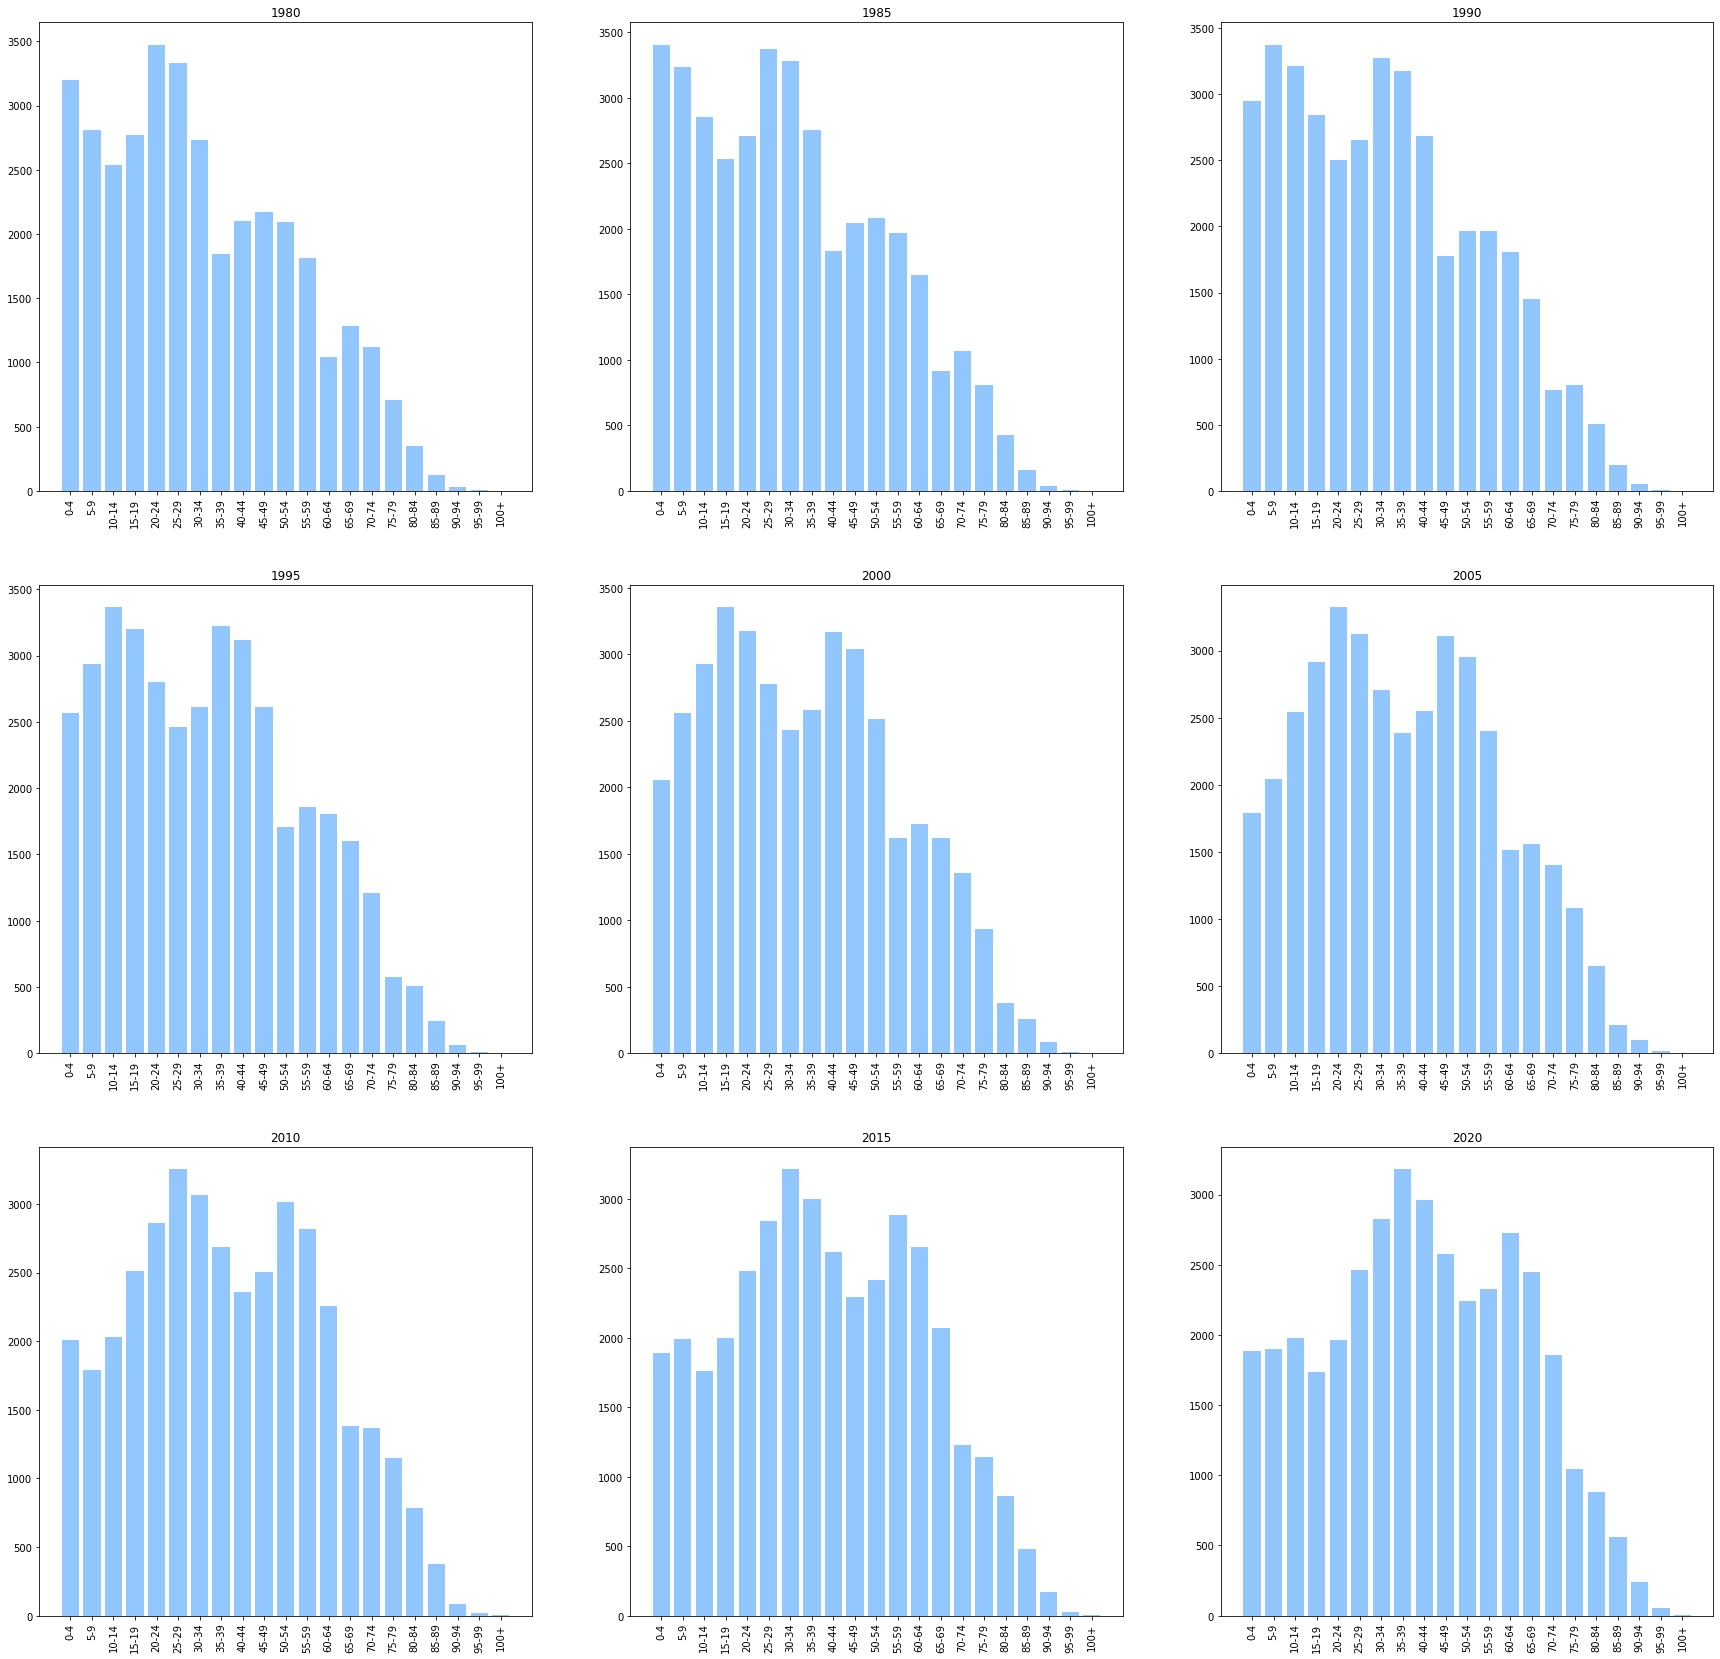

In [ ]:
fig = plt.figure(figsize=(30,50))
for i, (name, row) in enumerate(dp.iloc[6:].iterrows()):
    ax = plt.subplot(5, 3, i+1)
    ax.set_title(row['Reference date (as of 1 July)'])
    plt.bar(dp.iloc[:,1:].columns,row[1:])
    plt.xticks(rotation='vertical')

### Survivial rate calculation

In [ ]:
def survival_rate(demographic_profile_df, start = 2015, until = 2020):
  demographic_profile_df_start = demographic_profile_df[demographic_profile_df['Reference date (as of 1 July)'] == start].to_numpy().flatten()
  demographic_profile_df_until = demographic_profile_df[demographic_profile_df['Reference date (as of 1 July)'] == until].to_numpy().flatten()
  survival_rate = demographic_profile_df_until[2:] / demographic_profile_df_start[1:-1]
  return survival_rate

In [ ]:
dp_m

,Reference date (as of 1 July),0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
3195,1950,1500,1022,1170.998,1203.999,1159.001,999.999,623.001,809.999,850.001,...,391.999,311.999,218,140.001,90,44.497,16.298,3.719,0.464,0.029
3196,1955,1808.925,1476.825,1016.226,1162.662,1186.35,1136.342,979.909,608.534,787.084,...,504.475,343.396,253.623,159.543,87.899,44.87,16.118,4.032,0.588,0.045
3197,1960,1836.505,1773.521,1457.443,988.783,1121.039,1162.387,1119.782,959.882,572.206,...,645.393,455.355,281.794,189.853,102.749,44.158,16.883,4.271,0.677,0.06
3198,1965,1438.326,1817.89,1763.804,1447.708,978.309,1105.261,1145.449,1103.27,945.122,...,762.889,582.207,387.292,220.115,129.324,56.542,17.849,4.575,0.684,0.065
3199,1970,1309.004,1421.544,1803.688,1751.07,1427.421,960.609,1086.96,1125.506,1080.367,...,698.221,687.71,494.106,299.378,148.923,70.606,22.723,4.832,0.78,0.069
3200,1975,1436.354,1294.308,1416.627,1792.719,1723.373,1403.339,943.669,1066.836,1098.514,...,502.785,633.287,586.759,382.184,199.483,82.405,29.366,6.144,0.803,0.075
3201,1980,1633.854,1432.598,1292.364,1413.953,1774.593,1691.575,1377.284,922.809,1038.1,...,815.072,450.2,540.414,454.787,257.039,109.896,33.902,8.067,1.071,0.084
3202,1985,1744.819,1655.522,1458.804,1292.422,1381.996,1719.011,1657.51,1381.668,907.558,...,907.892,712.235,376.026,417.013,295.877,134.939,44.205,9.511,1.497,0.118
3203,1990,1509.602,1728.753,1644.565,1450.684,1276.144,1350.648,1660.462,1596.278,1336.368,...,918.366,802.1,595.858,290.813,282.319,161.47,53.909,11.769,1.572,0.145
3204,1995,1314.536,1502.656,1724.353,1634.837,1429.32,1251.093,1324.061,1625.878,1552.093,...,863.952,809.97,669.906,459.644,199.031,157.909,66.65,14.556,1.881,0.145


In [ ]:
survival_rate(dp_m)

array([1.0031901180529152, 0.9897693628974245, 0.9737801820587527,
       0.974620020014923, 0.9940186136526344, 0.9970917870792061,
       0.9912527579698933, 0.9855684788924902, 0.9800938136413714,
       0.968289797302658, 0.9474413367668828, 0.9215906325990276,
       0.8912180906372061, 0.852842399592177, 0.7945335133490682,
       0.7035658929314834, 0.584425208464929, 0.44980871892591673,
       0.31783501949247805, 0.21557420968030006], dtype=object)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

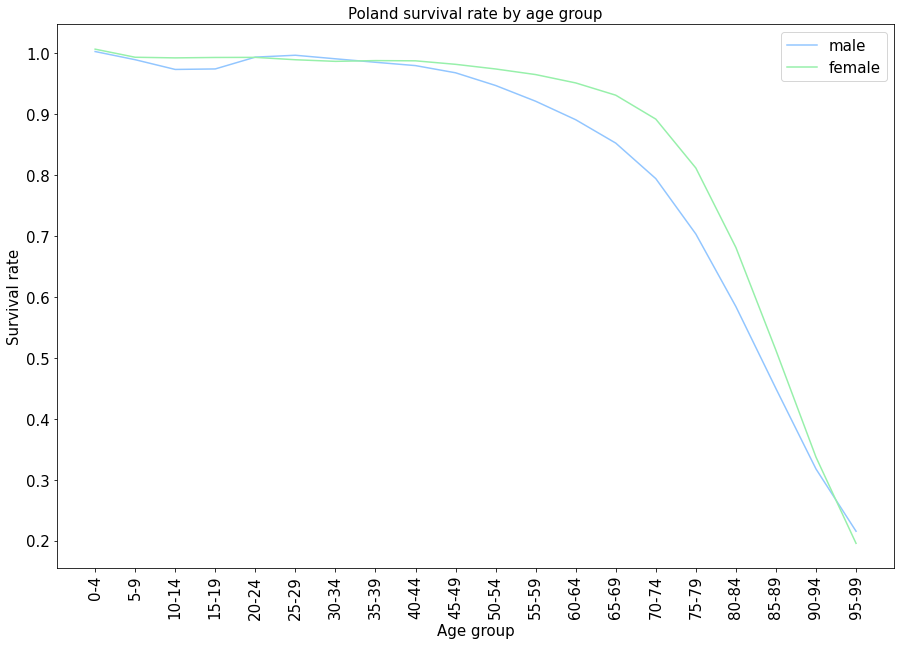

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.plot(dp_m.iloc[:,1:-1].columns, survival_rate(dp_m), label = 'male')
plt.plot(dp_f.iloc[:,1:-1].columns, survival_rate(dp_f), label = 'female')
plt.xlabel('Age group', fontsize=15)
plt.ylabel('Survival rate', fontsize=15)
plt.title(f'{target_country} survival rate by age group', fontsize=15)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation='vertical')

## 1.2 Determination of fertility rate

In [ ]:
dp_2020 = dp[dp['Reference date (as of 1 July)'] == 2020]
dp_2020_0_4 = dp_2020.iloc[0,2]
dp_2020_0_4

dp_f_2020_20_39 = dp_f[dp_f['Reference date (as of 1 July)'] == 2020][['20-24','25-29','30-34','35-39']].values.flatten()
dp_f_2020_20_39 = dp_f_2020_20_39.sum()


f_rate = dp_2020_0_4/dp_f_2020_20_39
f_rate

0.37541635109573673

## 1.3 Calculation of boys/girls ratio for newborns

In [ ]:
bg_ratio = dp_m[dp_m['Reference date (as of 1 July)']==2020]['0-4'].values / dp_f[dp_f['Reference date (as of 1 July)']==2020]['0-4'].values
bg_ratio


array([1.0541894844675483], dtype=object)

## 1.4 Prediction of the change in country's population and demographic profile for 100 years

### Model and forecastiong

In [ ]:
# define the model starting point
dp_m_2020 = dp_m[dp_m['Reference date (as of 1 July)'] == 2020]
dp_f_2020 = dp_f[dp_f['Reference date (as of 1 July)'] == 2020]
dp_m_2020.iloc[:,1:]

,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
3209,967.319,973.593,1011.282,881.682,995.319,1263.507,1470.157,1646.565,1502.714,1291.697,...,1128.396,1280.235,1094.529,779.602,399.586,299.133,165.615,61.846,13.289,1.207


In [ ]:
dp_m_2020.iloc[:,1:]

,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
3209,967.319,973.593,1011.282,881.682,995.319,1263.507,1470.157,1646.565,1502.714,1291.697,...,1128.396,1280.235,1094.529,779.602,399.586,299.133,165.615,61.846,13.289,1.207


In [ ]:
survival_rate(dp_m)

array([1.0031901180529152, 0.9897693628974245, 0.9737801820587527,
       0.974620020014923, 0.9940186136526344, 0.9970917870792061,
       0.9912527579698933, 0.9855684788924902, 0.9800938136413714,
       0.968289797302658, 0.9474413367668828, 0.9215906325990276,
       0.8912180906372061, 0.852842399592177, 0.7945335133490682,
       0.7035658929314834, 0.584425208464929, 0.44980871892591673,
       0.31783501949247805, 0.21557420968030006], dtype=object)

In [ ]:
dp_m_2020.iloc[:,1:-1]

,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99
3209,967.319,973.593,1011.282,881.682,995.319,1263.507,1470.157,1646.565,1502.714,1291.697,1110.61,1128.396,1280.235,1094.529,779.602,399.586,299.133,165.615,61.846,13.289


In [ ]:
def model_forecast_fertility_constant(starting_point_male, starting_point_female, fertility_rate, boys_and_girls_rate, survival_rate_male, survival_rate_female, forecast_range):
  prediction = []
  years = []
  starting_point_male = starting_point_male.values.flatten()
  starting_point_female = starting_point_female.values.flatten()
  prediction.append(round((starting_point_male + starting_point_female).sum()))
  years = (list(range(2020, 2020+forecast_range+5, 5)))
  for i in range(int(forecast_range//5)):
    next_male = starting_point_male * survival_rate_male
    male_kids = starting_point_female[5:9] * fertility_rate * (1 / (1 + 1 / bg_ratio))
    next_male = np.insert(next_male, 0, male_kids.sum(), axis = 0)
    next_female = starting_point_female * survival_rate_female
    female_kids = starting_point_female[5:9] * fertility_rate * (1 - 1 / (1 + 1 / bg_ratio))
    next_female = np.insert(next_female, 0, female_kids.sum(), axis = 0)
    next_point = (next_male + next_female).sum()
    starting_point_male = next_male[:-1]
    starting_point_female = next_female[:-1]
    prediction.append(round(float((next_point))))
  return prediction, years

In [ ]:
# def model_forecast_fertility_updated(starting_point_male, starting_point_female, fertility_rate, boys_and_girls_rate, survival_rate_male, survival_rate_female, forecast_range):
#   prediction = []
#   years = []
#   starting_point_male = starting_point_male.values.flatten()
#   starting_point_female = starting_point_female.values.flatten()
#   prediction.append(round((starting_point_male + starting_point_female).sum()))
#   years = (list(range(2020, 2020+forecast_range+5, 5)))
#   for i in range(int(forecast_range//5)):
#     next_male = starting_point_male * survival_rate_male
#     male_kids = starting_point_female[5:9] * fertility_rate * (1 / (1 + 1 / bg_ratio))
#     next_male = np.insert(next_male, 0, male_kids.sum(), axis = 0)
#     next_female = starting_point_female * survival_rate_female
#     female_kids = starting_point_female[5:9] * fertility_rate * (1 - 1 / (1 + 1 / bg_ratio))
#     next_female = np.insert(next_female, 0, female_kids.sum(), axis = 0)
#     next_point = (next_male + next_female).sum()
#     starting_point_male = next_male[:-1]
#     starting_point_female = next_female[:-1]
#     fertility_rate = (starting_point_female[0] + starting_point_male[0]) / starting_point_female[5:9].sum()
#     prediction.append(round(float((next_point))))
#   return prediction, years

In [ ]:
forecast, years = model_forecast_fertility_constant(dp_m_2020.iloc[:,1:-1], dp_f_2020.iloc[:,1:-1], f_rate, bg_ratio, survival_rate(dp_m), survival_rate(dp_f), 100)
forecast

[37842,
 37651,
 37078,
 36067,
 34744,
 33229,
 31710,
 30320,
 28975,
 27617,
 26238,
 24850,
 23547,
 22400,
 21400,
 20499,
 19642,
 18778,
 17902,
 17035,
 16210]

In [ ]:
dp_m_2020.iloc[:,1:-1].values.flatten()

array([967.319, 973.593, 1011.282, 881.682, 995.319, 1263.507, 1470.157,
       1646.565, 1502.714, 1291.697, 1110.61, 1128.396, 1280.235,
       1094.529, 779.602, 399.586, 299.133, 165.615, 61.846, 13.289],
      dtype=object)

### Visualization

(array([1925., 1950., 1975., 2000., 2025., 2050., 2075., 2100., 2125.,
        2150.]), <a list of 10 Text major ticklabel objects>)

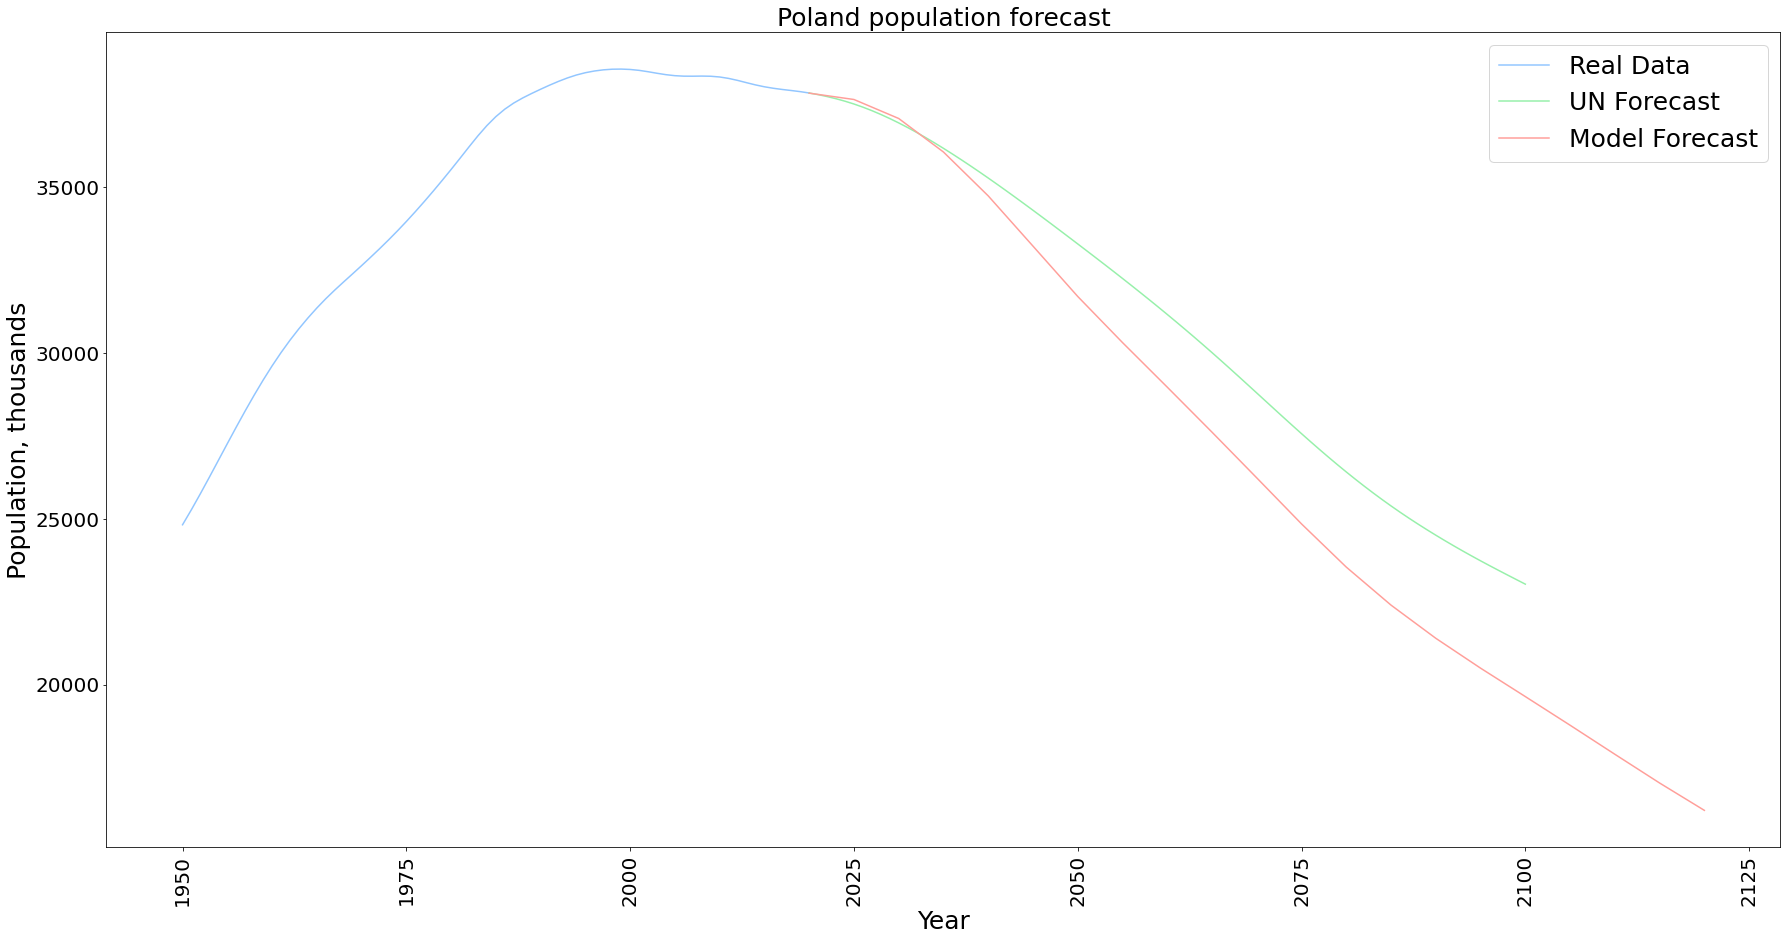

In [ ]:
fig = plt.figure(figsize=(30,15))
plt.title(f"{target_country} population forecast", fontsize=25)
plt.plot([int(i) for i in total_population_both_target.iloc[:,7:].columns], total_population_both_target.iloc[:,7:].values.flatten(), label='Real Data')
plt.plot([int(i) for i in total_population_both_forecast_target.iloc[:,7:].columns], total_population_both_forecast_target.iloc[:,7:].values.flatten(), label='UN Forecast')
plt.plot(years, forecast, label='Model Forecast')
plt.legend(fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Population, thousands', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation='vertical')

# Lab 2

* Perform a sensitivity analysis for a demographic model with respect to a set of parameters: fertility rate, boys/girls ratio, «survival» rate for different age groups (not all can be taken). Model output: number of inhabitants for a given year. Test on the final forecast values ​​for 10, 20, 50, 100 years.
* Define ranges of model parameter values ​​from data for previous periods (1950-2000)
* Based on all ranges of parameter values, perform an uncertainty analysis in the form of a graph with confidence intervals of the results. The values ​​between the boundaries can be considered evenly distributed.

## 2.0 Model defining

In [ ]:
def Model(fertility_rate, boys_and_girls_rate, 
          survival_rate_male_0_4, survival_rate_female_0_4,
          survival_rate_male_5_9, survival_rate_female_5_9, 
          survival_rate_male_10_14, survival_rate_female_10_14, 
          survival_rate_male_14_19, survival_rate_female_14_19,
          survival_rate_male_20_24, survival_rate_female_20_24,
          survival_rate_male_25_29, survival_rate_female_25_29,
          survival_rate_male_30_34, survival_rate_female_30_34,
          survival_rate_male_35_39, survival_rate_female_35_39,
          survival_rate_male_40_44, survival_rate_female_40_44,
          survival_rate_male_45_49, survival_rate_female_45_49,
          survival_rate_male_50_54, survival_rate_female_50_54,
          survival_rate_male_55_59, survival_rate_female_55_59,
          survival_rate_male_60_64, survival_rate_female_60_64,
          survival_rate_male_65_69, survival_rate_female_65_69,
          survival_rate_male_70_74, survival_rate_female_70_74,
          survival_rate_male_75_79, survival_rate_female_75_79,
          survival_rate_male_80_84, survival_rate_female_80_84,
          survival_rate_male_85_89, survival_rate_female_85_89,
          survival_rate_male_90_94, survival_rate_female_90_94,
          survival_rate_male_95_99, survival_rate_female_95_99):
  global dp_m_2020, dp_f_2020, survival_rate_male, survival_rate_female
  prediction_arr=[]
  for y in ([10, 20, 50, 100]):
    prediction=[]
    survival_rate_male = np.array([survival_rate_male_0_4,
            survival_rate_male_5_9,
            survival_rate_male_10_14, 
            survival_rate_male_14_19,
            survival_rate_male_20_24,
            survival_rate_male_25_29,
            survival_rate_male_30_34,
            survival_rate_male_35_39,
            survival_rate_male_40_44,
            survival_rate_male_45_49,
            survival_rate_male_50_54,
            survival_rate_male_55_59,
            survival_rate_male_60_64,
            survival_rate_male_65_69,
            survival_rate_male_70_74,
            survival_rate_male_75_79,
            survival_rate_male_80_84,
            survival_rate_male_85_89,
            survival_rate_male_90_94,
            survival_rate_male_95_99])
    survival_rate_female = np.array([survival_rate_female_0_4,
            survival_rate_female_5_9,
            survival_rate_female_10_14, 
            survival_rate_female_14_19,
            survival_rate_female_20_24,
            survival_rate_female_25_29,
            survival_rate_female_30_34,
            survival_rate_female_35_39,
            survival_rate_female_40_44,
            survival_rate_female_45_49,
            survival_rate_female_50_54,
            survival_rate_female_55_59,
            survival_rate_female_60_64,
            survival_rate_female_65_69,
            survival_rate_female_70_74,
            survival_rate_female_75_79,
            survival_rate_female_80_84,
            survival_rate_female_85_89,
            survival_rate_female_90_94,
            survival_rate_female_95_99])
    starting_point_male = dp_m_2020.iloc[:,1:-1].values.flatten()
    starting_point_female = dp_f_2020.iloc[:,1:-1].values.flatten()
    prediction.append(round((starting_point_male + starting_point_female).sum()))
    for i in range(int(y//5)):
      next_male = starting_point_male * survival_rate_male
      male_kids = starting_point_female[5:9] * fertility_rate * (1 / (1 + 1 / bg_ratio))
      next_male = np.insert(next_male, 0, male_kids.sum(), axis = 0)
      next_female = starting_point_female * survival_rate_female
      female_kids = starting_point_female[5:9] * fertility_rate * (1 - 1 / (1 + 1 / bg_ratio))
      next_female = np.insert(next_female, 0, female_kids.sum(), axis = 0)
      next_point = (next_male + next_female).sum()
      starting_point_male = next_male[:-1]
      starting_point_female = next_female[:-1]
      prediction.append(round(float((next_point))))
      prediction_sum = sum(np.array(prediction))
    prediction_arr.append(prediction[-1])
  return prediction_arr

In [ ]:
def Evaluate(param_values, n):
    Y = []
    for params in param_values:
        (fertility_rate, boys_and_girls_rate,
          survival_rate_male_0_4, survival_rate_female_0_4,
          survival_rate_male_5_9, survival_rate_female_5_9,
          survival_rate_male_10_14, survival_rate_female_10_14,
          survival_rate_male_14_19, survival_rate_female_14_19,
          survival_rate_male_20_24, survival_rate_female_20_24,
          survival_rate_male_25_29, survival_rate_female_25_29,
          survival_rate_male_30_34, survival_rate_female_30_34,
          survival_rate_male_35_39, survival_rate_female_35_39,
          survival_rate_male_40_44, survival_rate_female_40_44,
          survival_rate_male_45_49, survival_rate_female_45_49,
          survival_rate_male_50_54, survival_rate_female_50_54,
          survival_rate_male_55_59, survival_rate_female_55_59,
          survival_rate_male_60_64, survival_rate_female_60_64,
          survival_rate_male_65_69, survival_rate_female_65_69,
          survival_rate_male_70_74, survival_rate_female_70_74,
          survival_rate_male_75_79, survival_rate_female_75_79,
          survival_rate_male_80_84, survival_rate_female_80_84,
          survival_rate_male_85_89, survival_rate_female_85_89,
          survival_rate_male_90_94, survival_rate_female_90_94,
          survival_rate_male_95_99, survival_rate_female_95_99) = params
        res = Model(fertility_rate, boys_and_girls_rate, 
          survival_rate_male_0_4, survival_rate_female_0_4,
          survival_rate_male_5_9, survival_rate_female_5_9,
          survival_rate_male_10_14, survival_rate_female_10_14,
          survival_rate_male_14_19, survival_rate_female_14_19,
          survival_rate_male_20_24, survival_rate_female_20_24,
          survival_rate_male_25_29, survival_rate_female_25_29,
          survival_rate_male_30_34, survival_rate_female_30_34,
          survival_rate_male_35_39, survival_rate_female_35_39,
          survival_rate_male_40_44, survival_rate_female_40_44,
          survival_rate_male_45_49, survival_rate_female_45_49,
          survival_rate_male_50_54, survival_rate_female_50_54,
          survival_rate_male_55_59, survival_rate_female_55_59,
          survival_rate_male_60_64, survival_rate_female_60_64,
          survival_rate_male_65_69, survival_rate_female_65_69,
          survival_rate_male_70_74, survival_rate_female_70_74,
          survival_rate_male_75_79, survival_rate_female_75_79,
          survival_rate_male_80_84, survival_rate_female_80_84,
          survival_rate_male_85_89, survival_rate_female_85_89,
          survival_rate_male_90_94, survival_rate_female_90_94,
          survival_rate_male_95_99, survival_rate_female_95_99)[n]                
        Y.append(res)
    return np.array(Y)

## 2.1 Defining ranges of model parameters

In [ ]:
years_range = (list(range(1950, 2020, 5)))

### Define historical min and max of survival rate by age

In [ ]:
survival_rate_by_years_m = pd.DataFrame(survival_rate(dp_m, start=1950, until=1955)).T
survival_rate_by_years_f = pd.DataFrame(survival_rate(dp_f, start=1950, until=1955)).T


for year in years_range[1:]:
  current_year_m = pd.DataFrame(survival_rate(dp_m, start=year, until=year+5)).T
  current_year_f = pd.DataFrame(survival_rate(dp_f, start=year, until=year+5)).T
  survival_rate_by_years_m = survival_rate_by_years_m.append(current_year_m, ignore_index=True)
  survival_rate_by_years_f = survival_rate_by_years_f.append(current_year_f, ignore_index=True)

min_survival_rate_by_years_f = survival_rate_by_years_f.min().values.flatten()
max_survival_rate_by_years_f = survival_rate_by_years_f.max().values.flatten()
min_survival_rate_by_years_m = survival_rate_by_years_m.min().values.flatten()
max_survival_rate_by_years_m = survival_rate_by_years_m.max().values.flatten()

### Define historical min and max boys and girls ratio

In [ ]:
bg_ratio_by_year = np.array([])
for year in years_range:
  bg_ratio_current = float(dp_m[dp_m['Reference date (as of 1 July)']==year]['0-4'].values / dp_f[dp_f['Reference date (as of 1 July)']==year]['0-4'].values)
  bg_ratio_by_year = np.append(bg_ratio_by_year, bg_ratio_current)

bg_ratio_min = bg_ratio_by_year.min()
bg_ratio_max = bg_ratio_by_year.max()

### Define min and max fertility rate

In [ ]:
years_range = (list(range(1950, 2025, 5)))

In [ ]:
f_rate_by_year = np.array([])
for year in years_range:
  f_rate_current = dp[dp['Reference date (as of 1 July)'] == year].iloc[0,2]/dp_f[dp_f['Reference date (as of 1 July)'] == year][['20-24','25-29','30-34','35-39']].values.flatten().sum()
  f_rate_by_year = np.append(f_rate_by_year, f_rate_current)

f_rate_min = f_rate_by_year.min()
f_rate_max = f_rate_by_year.max()

## 2.2 Sensitivity analysis

### Form a dictionary of ranges

In [ ]:
problem = {
    'num_vars': 42,
    'names': ['fertility_rate', 'boys_and_girls_rate', 
              'survival_rate_male_0_4', 'survival_rate_female_0_4', 
              'survival_rate_male_5_9', 'survival_rate_female_5_9', 
              'survival_rate_male_10_14', 'survival_rate_female_10_14', 
              'survival_rate_male_14_19', 'survival_rate_female_14_19',
              'survival_rate_male_20_24', 'survival_rate_female_20_24',
              'survival_rate_male_25_29', 'survival_rate_female_25_29',
              'survival_rate_male_30_34', 'survival_rate_female_30_34',
              'survival_rate_male_35_39', 'survival_rate_female_35_39',
              'survival_rate_male_40_44', 'survival_rate_female_40_44',
              'survival_rate_male_45_49', 'survival_rate_female_45_49',
              'survival_rate_male_50_54', 'survival_rate_female_50_54',
              'survival_rate_male_55_59', 'survival_rate_female_55_59',
              'survival_rate_male_60_64', 'survival_rate_female_60_64',
              'survival_rate_male_65_69', 'survival_rate_female_65_69',
              'survival_rate_male_70_74', 'survival_rate_female_70_74',
              'survival_rate_male_75_79', 'survival_rate_female_75_79',
              'survival_rate_male_80_84', 'survival_rate_female_80_84',
              'survival_rate_male_85_89', 'survival_rate_female_85_89',
              'survival_rate_male_90_94', 'survival_rate_female_90_94',
              'survival_rate_male_95_99', 'survival_rate_female_95_99'
              ],
    'bounds': [[f_rate_min, f_rate_max],
               [bg_ratio_min, bg_ratio_max],
               [min_survival_rate_by_years_m[0], max_survival_rate_by_years_m[0]], 
               [min_survival_rate_by_years_f[0], max_survival_rate_by_years_f[0]],
               [min_survival_rate_by_years_m[1], max_survival_rate_by_years_m[1]], 
               [min_survival_rate_by_years_f[1], max_survival_rate_by_years_f[1]],
               [min_survival_rate_by_years_m[2], max_survival_rate_by_years_m[2]], 
               [min_survival_rate_by_years_f[2], max_survival_rate_by_years_f[2]],
               [min_survival_rate_by_years_m[3], max_survival_rate_by_years_m[3]], 
               [min_survival_rate_by_years_f[3], max_survival_rate_by_years_f[3]],
               [min_survival_rate_by_years_m[4], max_survival_rate_by_years_m[4]], 
               [min_survival_rate_by_years_f[4], max_survival_rate_by_years_f[4]],
               [min_survival_rate_by_years_m[5], max_survival_rate_by_years_m[5]], 
               [min_survival_rate_by_years_f[5], max_survival_rate_by_years_f[5]],
               [min_survival_rate_by_years_m[6], max_survival_rate_by_years_m[6]], 
               [min_survival_rate_by_years_f[6], max_survival_rate_by_years_f[6]],
               [min_survival_rate_by_years_m[7], max_survival_rate_by_years_m[7]], 
               [min_survival_rate_by_years_f[7], max_survival_rate_by_years_f[7]],
               [min_survival_rate_by_years_m[8], max_survival_rate_by_years_m[8]], 
               [min_survival_rate_by_years_f[8], max_survival_rate_by_years_f[8]],
               [min_survival_rate_by_years_m[9], max_survival_rate_by_years_m[9]], 
               [min_survival_rate_by_years_f[9], max_survival_rate_by_years_f[9]],
               [min_survival_rate_by_years_m[10], max_survival_rate_by_years_m[10]], 
               [min_survival_rate_by_years_f[10], max_survival_rate_by_years_f[10]],
               [min_survival_rate_by_years_m[11], max_survival_rate_by_years_m[11]], 
               [min_survival_rate_by_years_f[11], max_survival_rate_by_years_f[11]],
               [min_survival_rate_by_years_m[12], max_survival_rate_by_years_m[12]], 
               [min_survival_rate_by_years_f[12], max_survival_rate_by_years_f[12]],
               [min_survival_rate_by_years_m[13], max_survival_rate_by_years_m[13]], 
               [min_survival_rate_by_years_f[13], max_survival_rate_by_years_f[13]],
               [min_survival_rate_by_years_m[14], max_survival_rate_by_years_m[14]], 
               [min_survival_rate_by_years_f[14], max_survival_rate_by_years_f[14]],
               [min_survival_rate_by_years_m[15], max_survival_rate_by_years_m[15]], 
               [min_survival_rate_by_years_f[15], max_survival_rate_by_years_f[15]],
               [min_survival_rate_by_years_m[16], max_survival_rate_by_years_m[16]], 
               [min_survival_rate_by_years_f[16], max_survival_rate_by_years_f[16]],
               [min_survival_rate_by_years_m[17], max_survival_rate_by_years_m[17]], 
               [min_survival_rate_by_years_f[17], max_survival_rate_by_years_f[17]],
               [min_survival_rate_by_years_m[18], max_survival_rate_by_years_m[18]], 
               [min_survival_rate_by_years_f[18], max_survival_rate_by_years_f[18]],
               [min_survival_rate_by_years_m[19], max_survival_rate_by_years_m[19]], 
               [min_survival_rate_by_years_f[19], max_survival_rate_by_years_f[19]]
               ]
}


### Sensitivity analysis

In [ ]:
# generate samples of parameters
param_values = saltelli.sample(problem, 1024)


In [ ]:
# Evaluate model results with different parameter samples
si = []
si_summed = []
for i in [0, 1, 2, 3]:
  Y_arr = Evaluate(param_values, i)
  Si = sobol.analyze(problem, Y_arr, print_to_console=False)
  si_summed.append(np.array([Si['S1'][0], Si['S1'][1], Si['S1'][2:].sum()]))
  si.append(Si['S1'])

In [ ]:
si_summed_df = pd.DataFrame(si_summed)
si_summed_df = si_summed_df.rename(columns = {0:'FR', 1:'B/G', 2:'SR'})
si_summed_df = si_summed_df.rename(index = {0:'10 years', 1:'20 years', 2:'50 years', 3:'100 years'})
si_summed_df 

,FR,B/G,SR
10 years,0.973194,0.0,0.027584
20 years,0.979626,0.0,0.020692
50 years,0.988745,0.0,0.010589
100 years,0.984521,0.0,0.012834


### Visualization

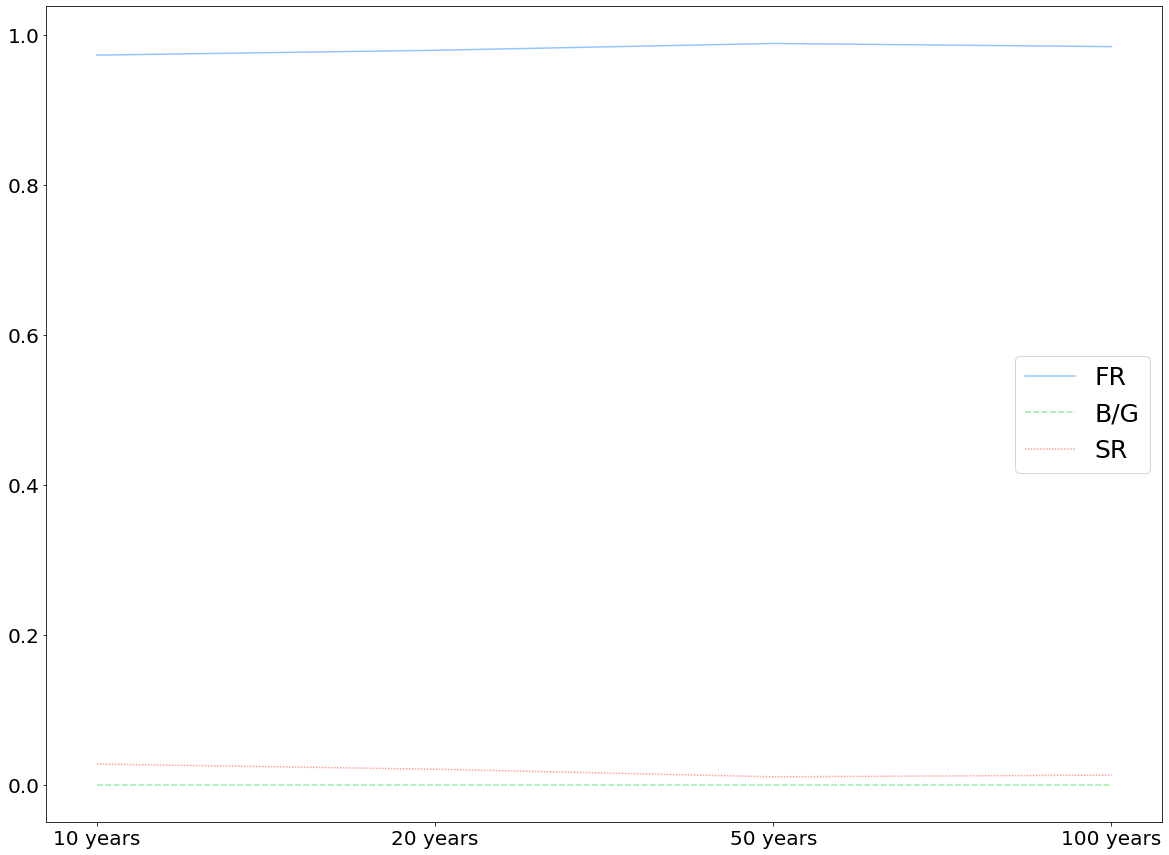

In [ ]:
fig = plt.figure(figsize=(20,15))
sns.lineplot(data=si_summed_df)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=25)

## 2.3 Uncertainty analysis

### Define model

In [ ]:
def Model(fertility_rate, boys_and_girls_rate, 
          survival_rate_male_0_4, survival_rate_female_0_4,
          survival_rate_male_5_9, survival_rate_female_5_9, 
          survival_rate_male_10_14, survival_rate_female_10_14, 
          survival_rate_male_14_19, survival_rate_female_14_19,
          survival_rate_male_20_24, survival_rate_female_20_24,
          survival_rate_male_25_29, survival_rate_female_25_29,
          survival_rate_male_30_34, survival_rate_female_30_34,
          survival_rate_male_35_39, survival_rate_female_35_39,
          survival_rate_male_40_44, survival_rate_female_40_44,
          survival_rate_male_45_49, survival_rate_female_45_49,
          survival_rate_male_50_54, survival_rate_female_50_54,
          survival_rate_male_55_59, survival_rate_female_55_59,
          survival_rate_male_60_64, survival_rate_female_60_64,
          survival_rate_male_65_69, survival_rate_female_65_69,
          survival_rate_male_70_74, survival_rate_female_70_74,
          survival_rate_male_75_79, survival_rate_female_75_79,
          survival_rate_male_80_84, survival_rate_female_80_84,
          survival_rate_male_85_89, survival_rate_female_85_89,
          survival_rate_male_90_94, survival_rate_female_90_94,
          survival_rate_male_95_99, survival_rate_female_95_99,
          ):
  global dp_m_2020, dp_f_2020, survival_rate_male, survival_rate_female
  prediction = []
  years = []
  survival_rate_male = np.array([survival_rate_male_0_4,
          survival_rate_male_5_9,
          survival_rate_male_10_14, 
          survival_rate_male_14_19,
          survival_rate_male_20_24,
          survival_rate_male_25_29,
          survival_rate_male_30_34,
          survival_rate_male_35_39,
          survival_rate_male_40_44,
          survival_rate_male_45_49,
          survival_rate_male_50_54,
          survival_rate_male_55_59,
          survival_rate_male_60_64,
          survival_rate_male_65_69,
          survival_rate_male_70_74,
          survival_rate_male_75_79,
          survival_rate_male_80_84,
          survival_rate_male_85_89,
          survival_rate_male_90_94,
          survival_rate_male_95_99])
  survival_rate_female = np.array([survival_rate_female_0_4,
          survival_rate_female_5_9,
          survival_rate_female_10_14, 
          survival_rate_female_14_19,
          survival_rate_female_20_24,
          survival_rate_female_25_29,
          survival_rate_female_30_34,
          survival_rate_female_35_39,
          survival_rate_female_40_44,
          survival_rate_female_45_49,
          survival_rate_female_50_54,
          survival_rate_female_55_59,
          survival_rate_female_60_64,
          survival_rate_female_65_69,
          survival_rate_female_70_74,
          survival_rate_female_75_79,
          survival_rate_female_80_84,
          survival_rate_female_85_89,
          survival_rate_female_90_94,
          survival_rate_female_95_99])
  starting_point_male = dp_m_2020.iloc[:,1:-1].values.flatten()
  starting_point_female = dp_f_2020.iloc[:,1:-1].values.flatten()
  prediction.append(round((starting_point_male + starting_point_female).sum()))
  years = (list(range(2020, 2020+100+5, 5)))
  for i in range(int(100//5)):
    next_male = starting_point_male * survival_rate_male
    male_kids = starting_point_female[5:9] * fertility_rate * (1 / (1 + 1 / bg_ratio))
    next_male = np.insert(next_male, 0, male_kids.sum(), axis = 0)
    next_female = starting_point_female * survival_rate_female
    female_kids = starting_point_female[5:9] * fertility_rate * (1 - 1 / (1 + 1 / bg_ratio))
    next_female = np.insert(next_female, 0, female_kids.sum(), axis = 0)
    next_point = (next_male + next_female).sum()
    starting_point_male = next_male[:-1]
    starting_point_female = next_female[:-1]
    prediction.append(round(float((next_point))))
    prediction_sum = sum(np.array(prediction))
  return prediction

def Evaluate(param_values):
    Y = []
    for params in param_values:
        (fertility_rate, boys_and_girls_rate,
          survival_rate_male_0_4, survival_rate_female_0_4,
          survival_rate_male_5_9, survival_rate_female_5_9,
          survival_rate_male_10_14, survival_rate_female_10_14,
          survival_rate_male_14_19, survival_rate_female_14_19,
          survival_rate_male_20_24, survival_rate_female_20_24,
          survival_rate_male_25_29, survival_rate_female_25_29,
          survival_rate_male_30_34, survival_rate_female_30_34,
          survival_rate_male_35_39, survival_rate_female_35_39,
          survival_rate_male_40_44, survival_rate_female_40_44,
          survival_rate_male_45_49, survival_rate_female_45_49,
          survival_rate_male_50_54, survival_rate_female_50_54,
          survival_rate_male_55_59, survival_rate_female_55_59,
          survival_rate_male_60_64, survival_rate_female_60_64,
          survival_rate_male_65_69, survival_rate_female_65_69,
          survival_rate_male_70_74, survival_rate_female_70_74,
          survival_rate_male_75_79, survival_rate_female_75_79,
          survival_rate_male_80_84, survival_rate_female_80_84,
          survival_rate_male_85_89, survival_rate_female_85_89,
          survival_rate_male_90_94, survival_rate_female_90_94,
          survival_rate_male_95_99, survival_rate_female_95_99) = params
        res = Model(fertility_rate, boys_and_girls_rate, 
          survival_rate_male_0_4, survival_rate_female_0_4,
          survival_rate_male_5_9, survival_rate_female_5_9,
          survival_rate_male_10_14, survival_rate_female_10_14,
          survival_rate_male_14_19, survival_rate_female_14_19,
          survival_rate_male_20_24, survival_rate_female_20_24,
          survival_rate_male_25_29, survival_rate_female_25_29,
          survival_rate_male_30_34, survival_rate_female_30_34,
          survival_rate_male_35_39, survival_rate_female_35_39,
          survival_rate_male_40_44, survival_rate_female_40_44,
          survival_rate_male_45_49, survival_rate_female_45_49,
          survival_rate_male_50_54, survival_rate_female_50_54,
          survival_rate_male_55_59, survival_rate_female_55_59,
          survival_rate_male_60_64, survival_rate_female_60_64,
          survival_rate_male_65_69, survival_rate_female_65_69,
          survival_rate_male_70_74, survival_rate_female_70_74,
          survival_rate_male_75_79, survival_rate_female_75_79,
          survival_rate_male_80_84, survival_rate_female_80_84,
          survival_rate_male_85_89, survival_rate_female_85_89,
          survival_rate_male_90_94, survival_rate_female_90_94,
          survival_rate_male_95_99, survival_rate_female_95_99)                
        Y.append(res)
    return np.array(Y)

param_values_ua = saltelli.sample(problem, 1024)
Y_ua = Evaluate(param_values)

### Visualize

(array([1925., 1950., 1975., 2000., 2025., 2050., 2075., 2100., 2125.,
        2150.]), <a list of 10 Text major ticklabel objects>)

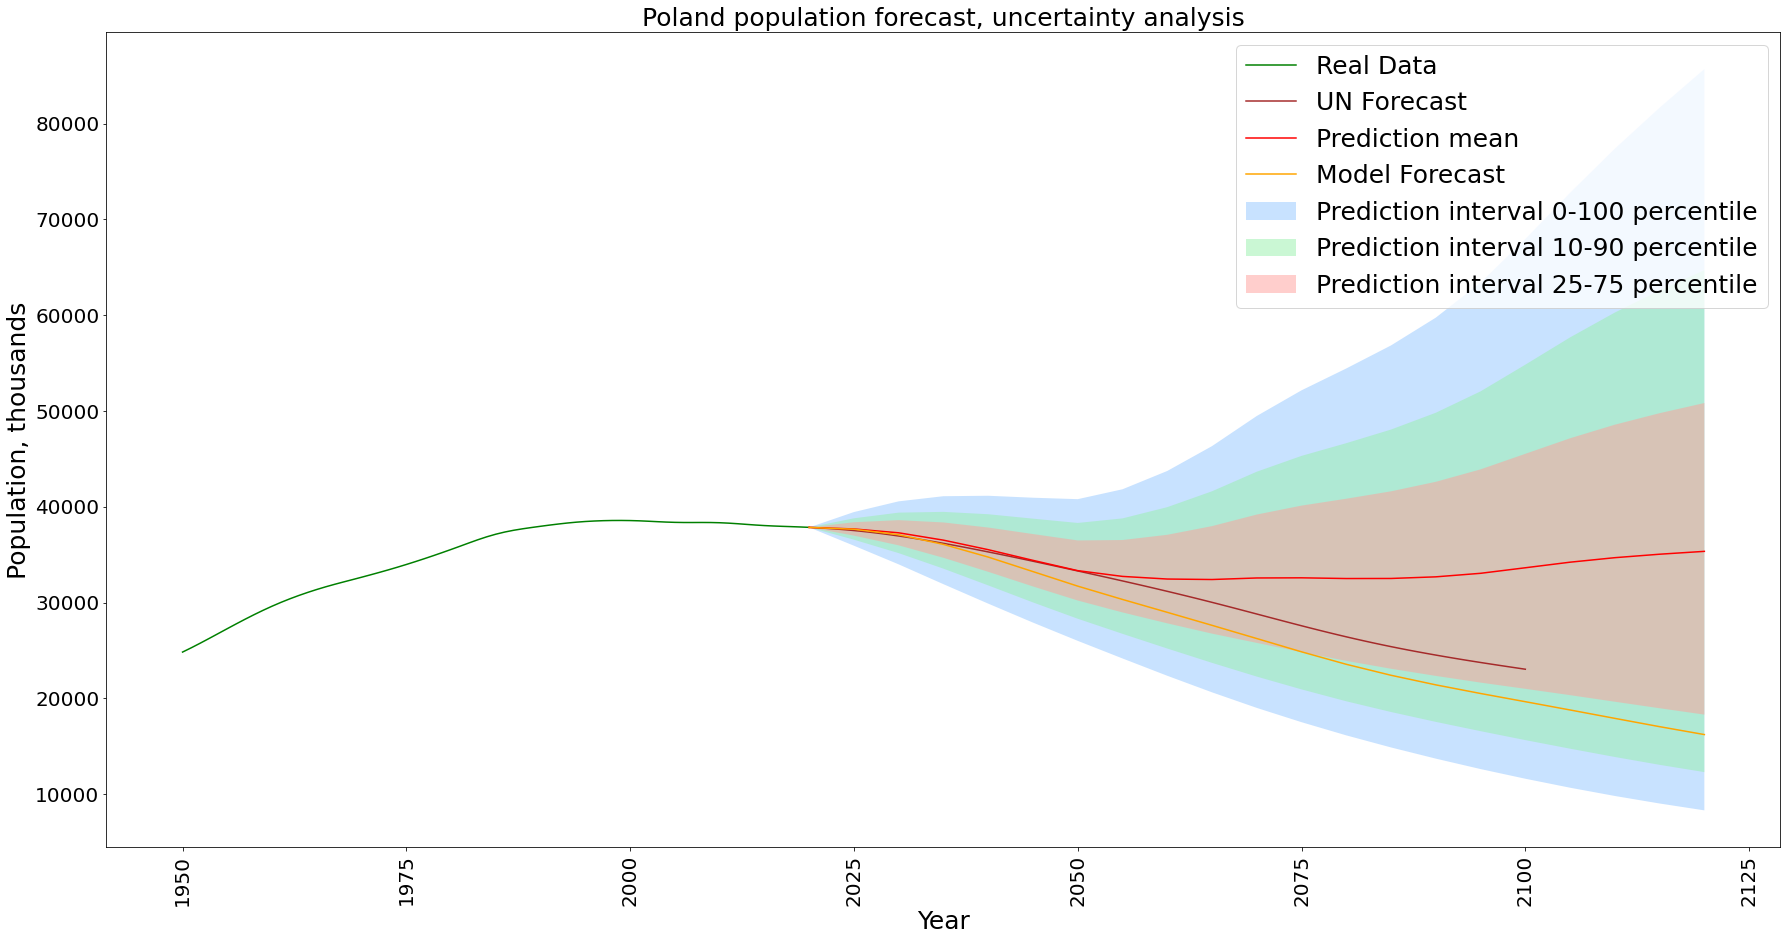

In [ ]:
fig = plt.figure(figsize=(30,15))
plt.title(f"{target_country} population forecast, uncertainty analysis", fontsize=25)
plt.plot([int(i) for i in total_population_both_target.iloc[:,7:].columns], total_population_both_target.iloc[:,7:].values.flatten(), label='Real Data', color='g')
plt.plot([int(i) for i in total_population_both_forecast_target.iloc[:,7:].columns], total_population_both_forecast_target.iloc[:,7:].values.flatten(), label='UN Forecast', color='brown')
plt.plot(years, pd.DataFrame(Y_ua).mean(), label='Prediction mean', color='r')
plt.fill_between(years, pd.DataFrame(Y_ua).max(), pd.DataFrame(Y_ua).min(), alpha=0.5, label='Prediction interval 0-100 percentile')
plt.fill_between(years, pd.DataFrame(Y_ua).quantile(0.9), pd.DataFrame(Y_ua).quantile(0.1), alpha=0.5, label='Prediction interval 10-90 percentile')
plt.fill_between(years, pd.DataFrame(Y_ua).quantile(0.25), pd.DataFrame(Y_ua).quantile(0.75), alpha=0.5, label='Prediction interval 25-75 percentile')
plt.plot(years, forecast, label='Model Forecast', color='orange')
plt.legend(fontsize=25)
plt.xlabel('Year', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Population, thousands', fontsize=25)
plt.xticks(rotation='vertical')
#plt.scatter(pd.DataFrame(param_values)[0], Y[Y<18292.75])